## Import Data


In [27]:
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
import pandas as pd
data = pd.read_csv('airquality (1).csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PM2.5   5999 non-null   int64
 1   co2     5999 non-null   int64
 2   no2     5999 non-null   int64
 3   so2     5999 non-null   int64
 4   o3      5999 non-null   int64
dtypes: int64(5)
memory usage: 234.5 KB


In [29]:
# data = data.drop(columns = ['Timestamp','deviceId','payload_id'])
# data

In [30]:
data.isnull().sum()

PM2.5    0
co2      0
no2      0
so2      0
o3       0
dtype: int64

In [31]:
data.isna().sum()

PM2.5    0
co2      0
no2      0
so2      0
o3       0
dtype: int64

In [32]:
data.duplicated().sum()

0

In [33]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [34]:
data.describe(

)

,PM2.5,co2,no2,so2,o3
count,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000
mean,20.614936,2330.332889,100.995833,132.494916,124.645774
std,11.985017,2092.686367,89.962540,120.542128,59.050665
min,3.000000,40.000000,5.000000,1.000000,10.000000
25%,11.000000,624.500000,27.000000,35.000000,77.000000
50%,18.000000,1183.000000,48.000000,59.000000,123.000000
75%,28.000000,4092.500000,174.000000,229.000000,167.000000
max,48.000000,6999.000000,300.000000,400.000000,250.000000


In [35]:
## cek data Oulier

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_indices = data[(data < lower_bound) | (data > upper_bound)].dropna(how='all').index
print(f"Number of potential outliers detected: {len(outlier_indices)}")

Number of potential outliers detected: 0


In [36]:
## Hapus data Oulier
data_cleaned_looped = data.copy() # Create a copy to avoid modifying the original data

while True:
    Q1 = data_cleaned_looped.quantile(0.25)
    Q3 = data_cleaned_looped.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = data_cleaned_looped[(data_cleaned_looped < lower_bound) | (data_cleaned_looped > upper_bound)].dropna(how='all').index

    if len(outlier_indices) == 0:
        print("No more outliers detected.")
        break
    else:
        print(f"Removing {len(outlier_indices)} potential outliers.")
        data_cleaned_looped = data_cleaned_looped.drop(outlier_indices)

print(f"Number of rows after removing outliers iteratively: {len(data_cleaned_looped)}")
display(data_cleaned_looped.head())

No more outliers detected.
Number of rows after removing outliers iteratively: 5999


,PM2.5,co2,no2,so2,o3
0,25,40,40,40,180
1,26,6286,145,201,157
2,36,1970,152,336,76
3,47,6837,150,382,210
4,40,3979,39,373,84


In [37]:
data_cleaned_looped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PM2.5   5999 non-null   int64
 1   co2     5999 non-null   int64
 2   no2     5999 non-null   int64
 3   so2     5999 non-null   int64
 4   o3      5999 non-null   int64
dtypes: int64(5)
memory usage: 234.5 KB


<Axes: >

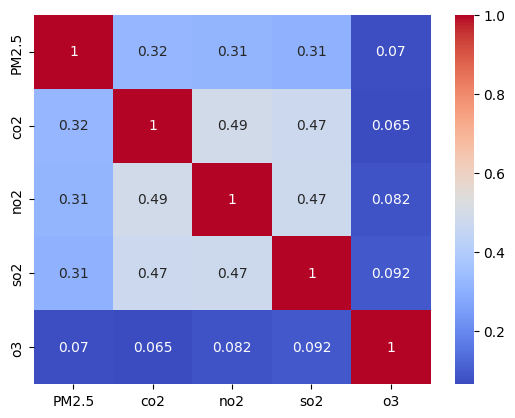

In [38]:
## Heatmap Data
import seaborn as sns
sns.heatmap(data_cleaned_looped.corr(), annot=True, cmap='coolwarm')

# Prepocessing

In [39]:
from sklearn.model_selection import train_test_split

# Asumsikan data_cleaned_looped adalah data numerik yang sudah dibersihkan
X = data_cleaned_looped.copy()

# Split sebelum apa pun!
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42, stratify=None)

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # FIT HANYA DI SINI
X_test_scaled = scaler.transform(X_test)         # HANYA TRANSFORM, TIDAK FIT

In [41]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

eps_values = np.arange(0.2, 2.0, 0.2)
min_samples_values = range(3, 10)

best_config = None
best_score = -1  # untuk silhouette (lebih tinggi lebih baik)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_train_scaled)
        
        # Jika semua noise atau hanya 1 cluster, skip
        if len(set(labels)) <= 1 or len(set(labels)) == 2 and -1 in set(labels):
            continue
        
        try:
            sil_score = silhouette_score(X_train_scaled, labels)
            dbi_score = davies_bouldin_score(X_train_scaled, labels)
            
            print(f"eps={eps}, min_samples={min_samples} "
                  f"=> silhouette={sil_score:.3f}, DBI={dbi_score:.3f}")
            
            # pilih berdasarkan silhouette
            if sil_score > best_score:
                best_score = sil_score
                best_config = (eps, min_samples, sil_score, dbi_score)
        
        except:
            continue

print("\n🔥 Best Config:")
print(f"eps={best_config[0]}, min_samples={best_config[1]}, "
      f"silhouette={best_config[2]:.3f}, DBI={best_config[3]:.3f}")


eps=0.2, min_samples=6 => silhouette=-0.001, DBI=1.188
eps=0.2, min_samples=7 => silhouette=-0.020, DBI=1.281
eps=0.2, min_samples=8 => silhouette=-0.026, DBI=1.283
eps=0.2, min_samples=9 => silhouette=0.072, DBI=1.103
eps=0.4, min_samples=3 => silhouette=-0.143, DBI=1.358
eps=0.4, min_samples=4 => silhouette=-0.043, DBI=1.747
eps=0.4, min_samples=5 => silhouette=0.113, DBI=1.343
eps=0.6000000000000001, min_samples=3 => silhouette=-0.042, DBI=1.406
eps=0.6000000000000001, min_samples=4 => silhouette=-0.056, DBI=1.454
eps=0.6000000000000001, min_samples=5 => silhouette=-0.102, DBI=1.473
eps=0.6000000000000001, min_samples=6 => silhouette=-0.135, DBI=1.564
eps=0.6000000000000001, min_samples=7 => silhouette=-0.120, DBI=1.611
eps=0.6000000000000001, min_samples=8 => silhouette=0.125, DBI=1.367
eps=0.8, min_samples=3 => silhouette=-0.015, DBI=2.151
eps=0.8, min_samples=4 => silhouette=-0.016, DBI=2.308
eps=0.8, min_samples=5 => silhouette=-0.092, DBI=1.807
eps=0.8, min_samples=6 => silhoue

In [42]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Parameter awal (bisa di-tune)
dbscan = DBSCAN(eps=0.6, min_samples=8)
train_clusters = dbscan.fit_predict(X_train_scaled)

# Jumlah cluster dan noise
n_clusters = len(set(train_clusters)) - (1 if -1 in train_clusters else 0)
n_noise = list(train_clusters).count(-1)

print(f"✅ Number of clusters found: {n_clusters}")
print(f"⚠️ Number of noise points: {n_noise}")
print(f"📊 Cluster labels: {np.unique(train_clusters)}")

✅ Number of clusters found: 3
⚠️ Number of noise points: 2743
📊 Cluster labels: [-1  0  1  2]


In [43]:
# Hanya evaluasi jika ada lebih dari 1 cluster (bukan semua noise)
if n_clusters > 1:
    try:
        sil_score = silhouette_score(X_train_scaled, train_clusters)
        print(f"🟢 Silhouette Score: {sil_score:.4f}")
    except ValueError as e:
        print(f"🟡 Silhouette Score: Cannot compute (likely because of noise or single cluster) — {e}")

    try:
        db_index = davies_bouldin_score(X_train_scaled, train_clusters[train_clusters != -1])
        print(f"🔵 Davies-Bouldin Index: {db_index:.4f}")
    except ValueError as e:
        print(f"🟡 Davies-Bouldin: Cannot compute — {e}")
else:
    print("🔴 Only 1 cluster or all noise — clustering quality metrics not applicable.")


🟢 Silhouette Score: 0.1250
🟡 Davies-Bouldin: Cannot compute — Found input variables with inconsistent numbers of samples: [4799, 2056]


In [44]:
X_train_scaled

array([[-0.55985506, -0.87394898, -0.79931123, -0.74795298,  0.33056917],
       [ 0.87370494,  1.96789262,  0.52130632, -0.05660065,  2.06285639],
       [-0.0538927 , -0.74167035,  1.89741201, -0.13989611,  1.58732657],
       ...,
       [-0.30687388, -0.78321634, -0.77711598, -0.78127117, -0.53557444],
       [-1.31879858, -1.00718268, -0.62174921, -0.8229189 ,  0.29660276],
       [ 0.70505082, -0.23977562, -0.85479937,  1.30944493,  2.13078922]])

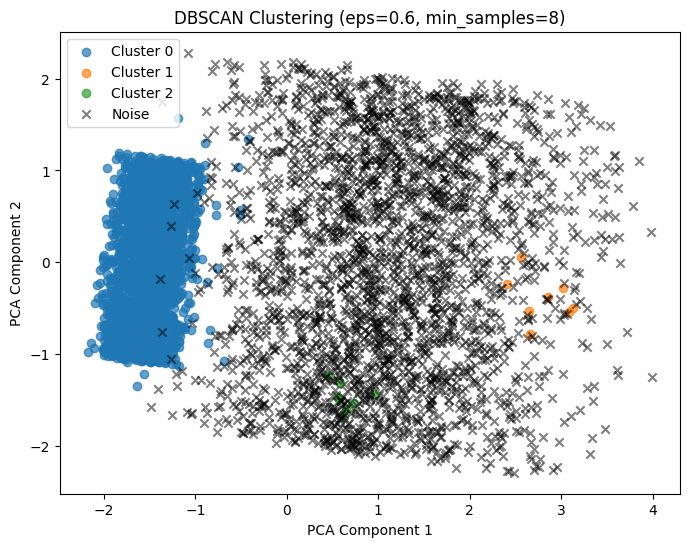

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Kurangi dimensi jadi 2 biar bisa divisualisasikan
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train_scaled)

# Plot hasil cluster
plt.figure(figsize=(8,6))
unique_labels = set(train_clusters)

for label in unique_labels:
    if label == -1:
        # Noise = warna hitam
        color = "k"
        plt.scatter(
            X_reduced[train_clusters == label, 0],
            X_reduced[train_clusters == label, 1],
            c=color, label="Noise", alpha=0.5, marker="x"
        )
    else:
        plt.scatter(
            X_reduced[train_clusters == label, 0],
            X_reduced[train_clusters == label, 1],
            label=f"Cluster {label}", alpha=0.7
        )

plt.title(f"DBSCAN Clustering (eps={dbscan.eps}, min_samples={dbscan.min_samples})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [46]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluate clustering performance
# Silhouette Score: Higher value means better defined clusters (range -1 to 1)
silhouette_avg = silhouette_score(X_train_scaled, train_clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Davies-Bouldin Index: Lower value means better clustering (0 indicates perfect separation)
db_index = davies_bouldin_score(X_train_scaled, train_clusters)
print(f"Davies-Bouldin Index: {db_index}")

Silhouette Score: 0.12501769040485747
Davies-Bouldin Index: 1.366560680553188


In [47]:
X_train = X_train.rename(columns={
    "co2": "CO",
    "no2": "NO2",
    "so2": "SO2",
    "o3": "O3"
})


In [49]:
import numpy as np
import pandas as pd

# --- Breakpoints AQI ---
# format: pollutant: [(Bmin, Bmax, Imin, Imax)]
aqi_breakpoints = {
    "PM2.5": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), 
              (91, 120, 201, 300), (121, 250, 301, 400)],
    "NO2":   [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200), 
              (181, 280, 201, 300), (281, 400, 301, 400)],
    "O3":    [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200), 
              (169, 208, 201, 300), (209, 748, 301, 400)],
    "SO2":   [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200), 
              (381, 800, 201, 300), (801, 1600, 301, 400)],
    "CO":    [(0, 1, 0, 50), (1.1, 2, 51, 100), (2.1, 10, 101, 200), 
              (10.1, 17, 201, 300), (17.1, 34, 301, 400)],
}

# --- Fungsi hitung sub-index ---
def calculate_subindex(pollutant, value):
    if pollutant not in aqi_breakpoints:
        return np.nan
    for Bmin, Bmax, Imin, Imax in aqi_breakpoints[pollutant]:
        if Bmin <= value <= Bmax:
            return ((Imax - Imin) / (Bmax - Bmin)) * (value - Bmin) + Imin
    return np.nan  # jika diluar range

# --- Fungsi hitung AQI per baris ---
def calculate_aqi(row):
    sub_indices = {}
    for pollutant in ["PM2.5", "NO2", "O3", "SO2", "CO"]:
        sub_indices[pollutant] = calculate_subindex(pollutant, row[pollutant])
    # Ambil sub-index tertinggi
    max_pollutant = max(sub_indices, key=sub_indices.get)
    max_value = sub_indices[max_pollutant]
    return max_value, max_pollutant

# --- Mapping kategori AQI ---
def categorize_aqi(value):
    if value <= 50: return "Good"
    elif value <= 100: return "Satisfactory"
    elif value <= 200: return "Moderate"
    elif value <= 300: return "Poor"
    elif value <= 400: return "Very Poor"
    else: return "Severe"

# --- Tambahkan ke DataFrame ---
# --- Tambahkan ke DataFrame ---
X_train["AQI_Value"], X_train["Dominant_Pollutant"] = zip(*X_train.apply(calculate_aqi, axis=1))
X_train["AQI_Category"] = X_train["AQI_Value"].apply(categorize_aqi)


AQI_Category  Good  Moderate  Poor  Satisfactory  Very Poor
Cluster                                                    
-1               1       954  1116            42        630
 0               9      1095   192           744          0
 1               0         0     8             0          0
 2               0         3     5             0          0


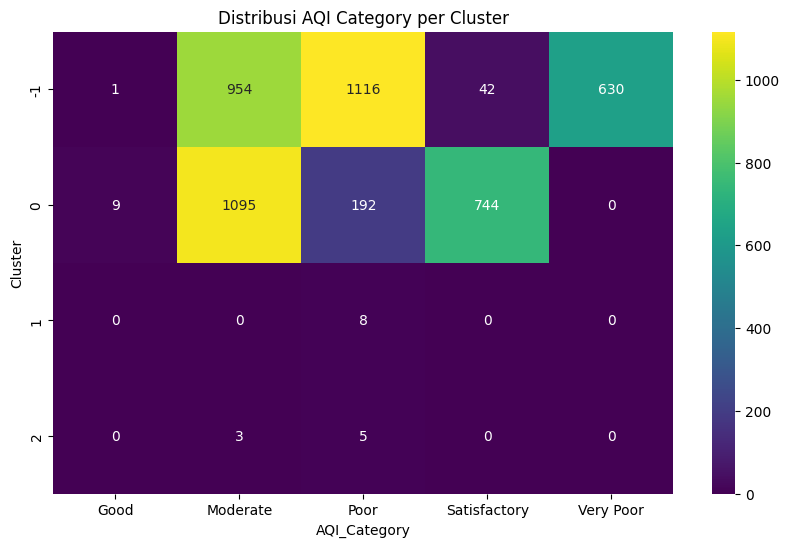

In [50]:
# Crosstab cluster vs AQI
crosstab = pd.crosstab(X_train["Cluster"], X_train["AQI_Category"])
print(crosstab)

plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, cmap="viridis", fmt="d")
plt.title("Distribusi AQI Category per Cluster")
plt.show()

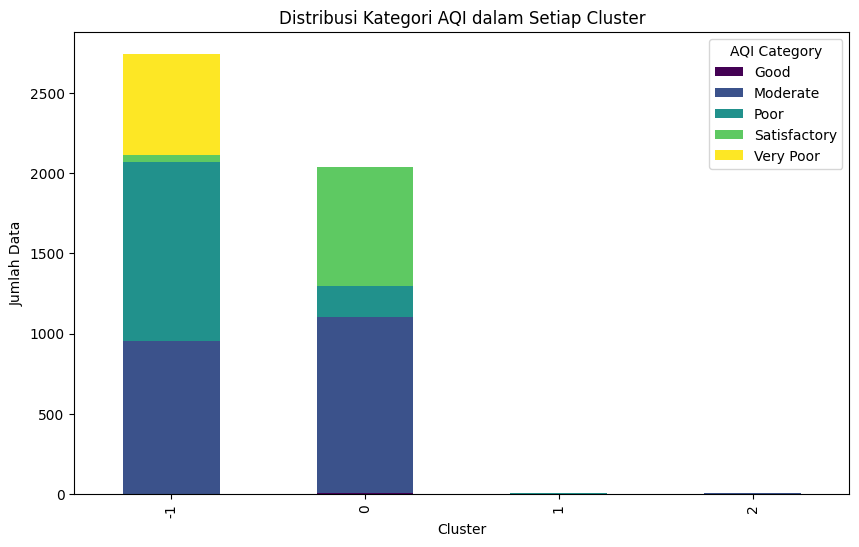

In [51]:
# Plot distribusi
crosstab.plot(kind="bar", stacked=True, figsize=(10,6), colormap="viridis")
plt.title("Distribusi Kategori AQI dalam Setiap Cluster")
plt.xlabel("Cluster"); plt.ylabel("Jumlah Data")
plt.legend(title="AQI Category")
plt.show()